In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u
# from bokeh_scripts import RS_img, img_ext

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
alldb = pd.read_pickle('../dataframes/fitdb/allfits_1D.pkl')
morph_db = alldb.query('W_UVJ == "Q" and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 ')

bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333, 30144, 21683]
# nog141 = [27915,37955,17746,17735]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]
# nog102 = []

inout = []
for i in morph_db.index:     
    if morph_db.id[i] not in bspec and morph_db.id[i] not in nog102: 
        inout.append('i')
    else:
        inout.append('o')
        
morph_db['inout'] = inout
mdb = morph_db.query('inout == "i" and 0.7 < zgrism < 2.5 and Sigma1 > 10**9.6')


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


# image panel

In [3]:
f105N = fits.open('/Volumes/Vince_CLEAR/Data/CLEAR/goodsn-F105W-astrodrizzle-v4.4_drz_sci.fits')
f105N_img = f105N[0].data

f105S = fits.open('/Volumes/Vince_CLEAR/Data/CLEAR/goodss-F105W-astrodrizzle-v4.4_drz_sci.fits')
f105S_img = f105S[0].data

v4N = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
v4S = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()

wfN = wcs.WCS(f105N[0].header)
wfS = wcs.WCS(f105S[0].header)

def RS_img(img):
    IMG = np.array(img) + 100

    m = np.percentile(IMG, 5)
    M = np.percentile(IMG, 99)

    IMG -= m
    IMG[IMG <= 0] = 0
    IMG /= (M-m)
    IMG[IMG > 1] =1
    return np.arcsinh(IMG)

def get_positions(ra, dec, D, W):
    [Of, Lf, Hf]=W.wcs_world2pix([[ra ,dec],[ra-D ,dec-D], [ra+D ,dec+D]],1)
    Of = Of.astype(int)
    Lf = Lf.astype(int)
    Hf = Hf.astype(int)
    return Of, Lf, Hf

def img_ext(field, gid):
    D = (2 * u.arcsec * (1*u.arcmin/(60*u.arcsec)) * (1*u.deg/(60*u.arcmin))).value

    if field == 'GND':
        ra=v4N.query('id == {}'.format(gid)).ra.values[0]
        dec=v4N.query('id == {}'.format(gid)).dec.values[0]
        W = wfN
    if field == 'GSD':
        ra=v4S.query('id == {}'.format(gid)).ra.values[0]
        dec=v4S.query('id == {}'.format(gid)).dec.values[0]
        W = wfS

    Of1, Lf1, Hf1 = get_positions(ra, dec, D, W)
    print(Lf1[0] - Hf1[0])
    print(Lf1[1] - Hf1[1])
    
    dx = np.abs(Of1[1] - Lf1[1])

    if field == 'GND':
        gal_img = f105N_img[Of1[1] - dx : Of1[1]+1 + dx , Of1[0] - dx: Of1[0]+1 + dx]
    if field == 'GSD':
        gal_img = f105S_img[Of1[1] - dx : Of1[1]+1 + dx , Of1[0] - dx: Of1[0]+1 + dx]
    return gal_img

59
-66
31
-67


([], <a list of 0 Text yticklabel objects>)

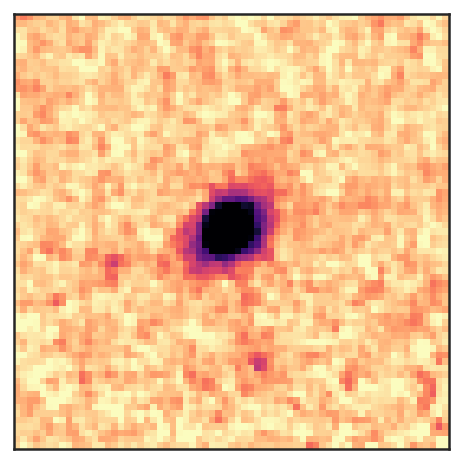

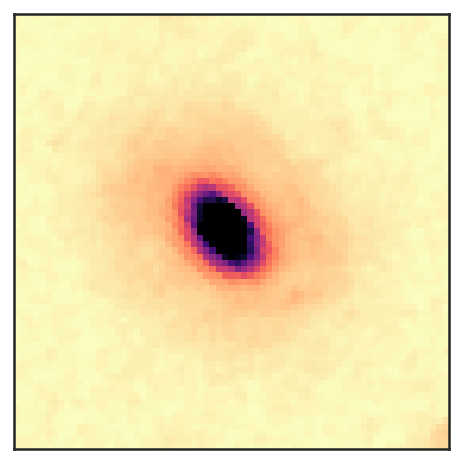

In [4]:
IMG = RS_img(img_ext('GSD',41520))
plt.figure()
plt.imshow(IMG, cmap = 'magma_r')
plt.xticks([])
plt.yticks([])

IMG = RS_img(img_ext('GND',21156))
plt.figure()
plt.imshow(IMG, cmap = 'magma_r')
plt.xticks([])
plt.yticks([])

# SFH Panel

In [5]:
from spec_tools import Gen_PPF
from spec_tools import Oldest_galaxy
from spec_id import logsfr_ratios_to_masses, get_agebins, convert_sfh
from scipy import stats
class Sfh_prior(object):
    def __init__(self, field, galaxy, trials = 5000):

        ppf_dict = {}
        params = ['a', 'lm']

        for i in params:
            x,px = np.load('../data/posteriors/{0}_{1}_tabfit_P{2}.npy'.format(field, galaxy, i))
            ppf_dict[i] = Gen_PPF(x,px)

        idx = 0
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(field, galaxy))
        rshift = x[px == max(px)][0]
        self.fulltimes = np.arange(0.0,Oldest_galaxy(rshift),0.01)
        sfr_grid = []

        while idx < trials:
            draw = np.zeros(len(params))

            for i in range(len(draw)):
                draw[i] = ppf_dict[params[i]](np.random.rand(1))[0]

            taus = stats.t.ppf( q = np.random.rand(10), loc = 0, scale = 0.3, df =2.)
            masses = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(draw[0]))
    
            time, sfr, tmax = convert_sfh(get_agebins(draw[0]), masses, maxage = draw[0]*1E9)

            T=[0]
            M=[0]
            for i in range(len(time)//2):
                mass = sfr[i*2+1] * (time[i*2+1] - time[i*2])
                M.append(M[i] + mass)
                T.append(time[i*2+1])

            sfr = sfr/ M[-1] * 10**draw[1] / 1E9
        
            lbt = np.abs(time - time[-1])[::-1]
            lbsfr = sfr[::-1]
        
            sfr_grid.append(interp1d(lbt,lbsfr,bounds_error=False,fill_value=0)(self.fulltimes))

            idx +=1
        SFH = []
        SFH_16 = []
        SFH_84 = []
        ftimes = []
        for i in range(len(np.array(sfr_grid).T)):
            adat = np.array(np.array(sfr_grid).T[i])
            gdat = adat[adat>0]
            if len(gdat) < trials * 0.1:
                break
            else:
                SFH.append(np.percentile(gdat,50))
                SFH_16.append(np.percentile(gdat,16))
                SFH_84.append(np.percentile(gdat,84))

                ftimes.append(self.fulltimes[i])

        self.SFH = np.array(SFH)
        self.SFH_16 = np.array(SFH_16)
        self.SFH_84 = np.array(SFH_84)
        self.LBT = np.array(ftimes)
        
        self.sfr_grid = np.array(sfr_grid)


Couldn't `import tristars`.  Get it from https://github.com/gbrammer/tristars to enable improved blind astrometric matching with triangle asterisms.



In [16]:
# import pickle
# SDB = pd.read_pickle('../bokeh_app/data/SFH.pkl')
# LBT = SDB.LBT
# Sdb = mdb.sort_values('z_50', ascending=False) 
# gs = gridspec.GridSpec(1,2, width_ratios=[1,3], wspace=0.25)


# for i in Sdb.index:
#     plt.figure(figsize=[9,2])
#     ax1 = plt.subplot(gs[0])
#     ax2 = plt.subplot(gs[1])
#     ax1.set_xticks([])
#     ax1.set_yticks([])
#     SFH = SDB['{}'.format(mdb.id[i])]
#     SFH_16 = SDB['{}_16'.format(mdb.id[i])]
#     SFH_84 = SDB['{}_84'.format(mdb.id[i])]

#     iSFH = interp1d(LBT,SFH)

#     ax2.plot(LBT,SFH, color = '#C1253C', label = '{}-{}'.format( mdb.field[i],  mdb.id[i]))
#     ax2.fill_between(LBT,SFH_16,SFH_84, color ='black', alpha=0.3)
#     ax2.set_title('zgrism={:1.3f},   z50={:1.3f},   t50={:1.3f} Gyr'.format(
#         mdb.zgrism[i], mdb.z_50[i],mdb.t_50[i]),fontsize=14)
#     ax2.scatter(mdb.t_50[i],iSFH(mdb.t_50[i]), marker='o', s=50, color = 'k')
#     IMG = np.load('../bokeh_app/data/imgs/{}_img.npy'.format(mdb.id[i]))
#     ax1.imshow(IMG[::-1], cmap = 'binary_r')
#     ax1.set_title('{:s}-{:d}'.format(mdb.field[i],  mdb.id[i]),fontsize=15)    
#     ax2.set_xlabel('Lookback Time (Gyr)', fontsize=15)
#     ax2.set_ylabel('SFR (yr$^{-1}$)', fontsize=15)
#     ax2.tick_params(axis='both', which='major', labelsize=12) 
        
#     plt.savefig('/Users/Vince.ec/vec_20_appendix/fullfigs/fullfig_{}-{}.png'.format(mdb.field[i],  mdb.id[i]), bbox_inches = 'tight')    

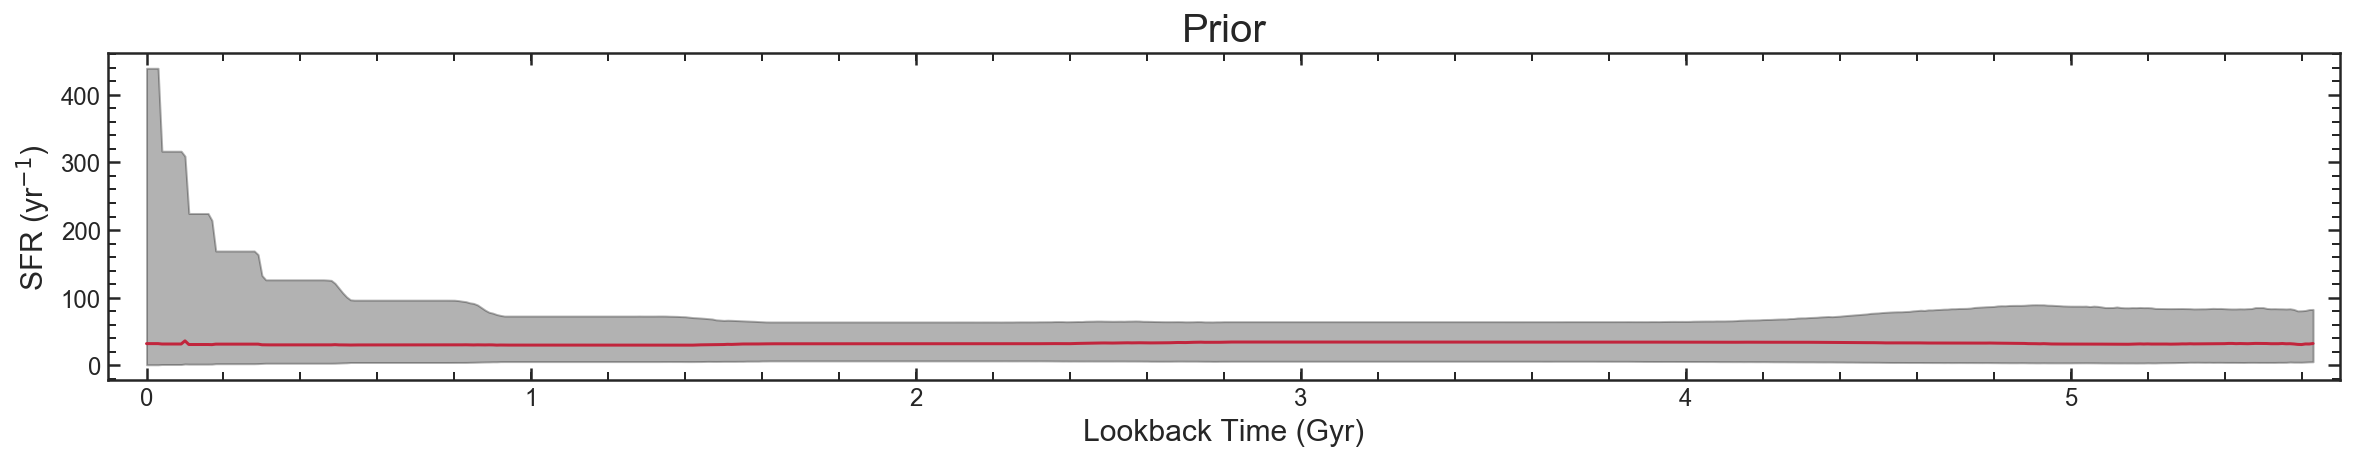

In [22]:
import pickle
SDB = pd.read_pickle('../bokeh_app/data/SFH.pkl')
LBT = SDB.LBT
Sdb = mdb.sort_values('z_50', ascending=False) 
gs = gridspec.GridSpec(5,4, width_ratios=[1,3,1,3], wspace=0.25, hspace = 0.6)

plt.figure(figsize=[20,3])

ax3 = plt.subplot()
SFH = Sfh_prior('GSD',  39170)
ax3.plot(SFH.LBT,SFH.SFH, color = '#C1253C', label = 'Prior')
ax3.fill_between(SFH.LBT,SFH.SFH_16,SFH.SFH_84, color ='black', alpha=0.3)
ax3.set_title('Prior',fontsize=20) 

ax3.set_xlabel('Lookback Time (Gyr)', fontsize=15)
ax3.set_ylabel('SFR (yr$^{-1}$)', fontsize=15)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.set_xlim(-0.1, 5.7)
        
# plt.savefig('../../Vince-ec.github.io/appendix/fullfigs/appendix_fullfig_{}.png'.format(FL), bbox_inches = 'tight')    
plt.savefig('/Users/Vince.ec/vec_20_appendix/fullfigs/fullfig_prior.png', bbox_inches = 'tight')    

In [28]:
import pickle
SDB = pd.read_pickle('../bokeh_app/data/SFH.pkl')
LBT = SDB.LBT
Sdb = mdb.sort_values('z_50', ascending=False) 
gs = gridspec.GridSpec(5,4, width_ratios=[1,3,1,3], wspace=0.25, hspace = 0.6)

plt.figure(figsize=[20,18])

# ID=-2
# FL=1
for i in range(5):
    for ii in range(2):
        idx = Sdb.index[ID]
        if ID>=0:
            ax1 = plt.subplot(gs[i,ii*2])
            ax2 = plt.subplot(gs[i,ii*2+1])
            ax1.set_xticks([])
            ax1.set_yticks([])
            SFH = SDB['{}'.format(mdb.id[idx])]
            SFH_16 = SDB['{}_16'.format(mdb.id[idx])]
            SFH_84 = SDB['{}_84'.format(mdb.id[idx])]

            iSFH = interp1d(LBT,SFH)
                
            ax2.plot(LBT,SFH, color = '#C1253C', label = '{}-{}'.format( mdb.field[idx],  mdb.id[idx]))
            ax2.fill_between(LBT,SFH_16,SFH_84, color ='black', alpha=0.3)
            ax2.set_title('zgrism={:1.3f},   z50={:1.3f},   t50={:1.3f} Gyr'.format(
                mdb.zgrism[idx], mdb.z_50[idx],mdb.t_50[idx]),fontsize=14)
            ax2.scatter(mdb.t_50[idx],iSFH(mdb.t_50[idx]), marker='o', s=50, color = 'k')
            IMG = np.load('../bokeh_app/data/imgs/{}_img.npy'.format(mdb.id[idx]))
            ax1.imshow(IMG[::-1], cmap = 'binary_r')
            ax1.set_title('{:s}-{:d}'.format(mdb.field[idx],  mdb.id[idx]),fontsize=15)    
            ax2.set_xlabel('Lookback Time (Gyr)', fontsize=15)
            ax2.set_ylabel('SFR (yr$^{-1}$)', fontsize=15)
            ax2.tick_params(axis='both', which='major', labelsize=12) 
            
        if ID==-2:  
            ax3 = plt.subplot(gs[0,:])
            SFH = Sfh_prior('GSD',  39170)
            ax3.plot(SFH.LBT,SFH.SFH, color = '#C1253C', label = 'Prior')
            ax3.fill_between(SFH.LBT,SFH.SFH_16,SFH.SFH_84, color ='black', alpha=0.3)
            ax3.set_title('Prior',fontsize=20) 
            
            ax3.set_xlabel('Lookback Time (Gyr)', fontsize=15)
            ax3.set_ylabel('SFR (yr$^{-1}$)', fontsize=15)
            ax3.tick_params(axis='both', which='major', labelsize=12)
            ax3.set_xlim(-0.1, 5.7)
        ID += 1
        
# plt.savefig('../../Vince-ec.github.io/appendix/fullfigs/appendix_fullfig_{}.png'.format(FL), bbox_inches = 'tight')    
FL+=1

IndexError: index 98 is out of bounds for axis 0 with size 98

<Figure size 1440x1296 with 0 Axes>

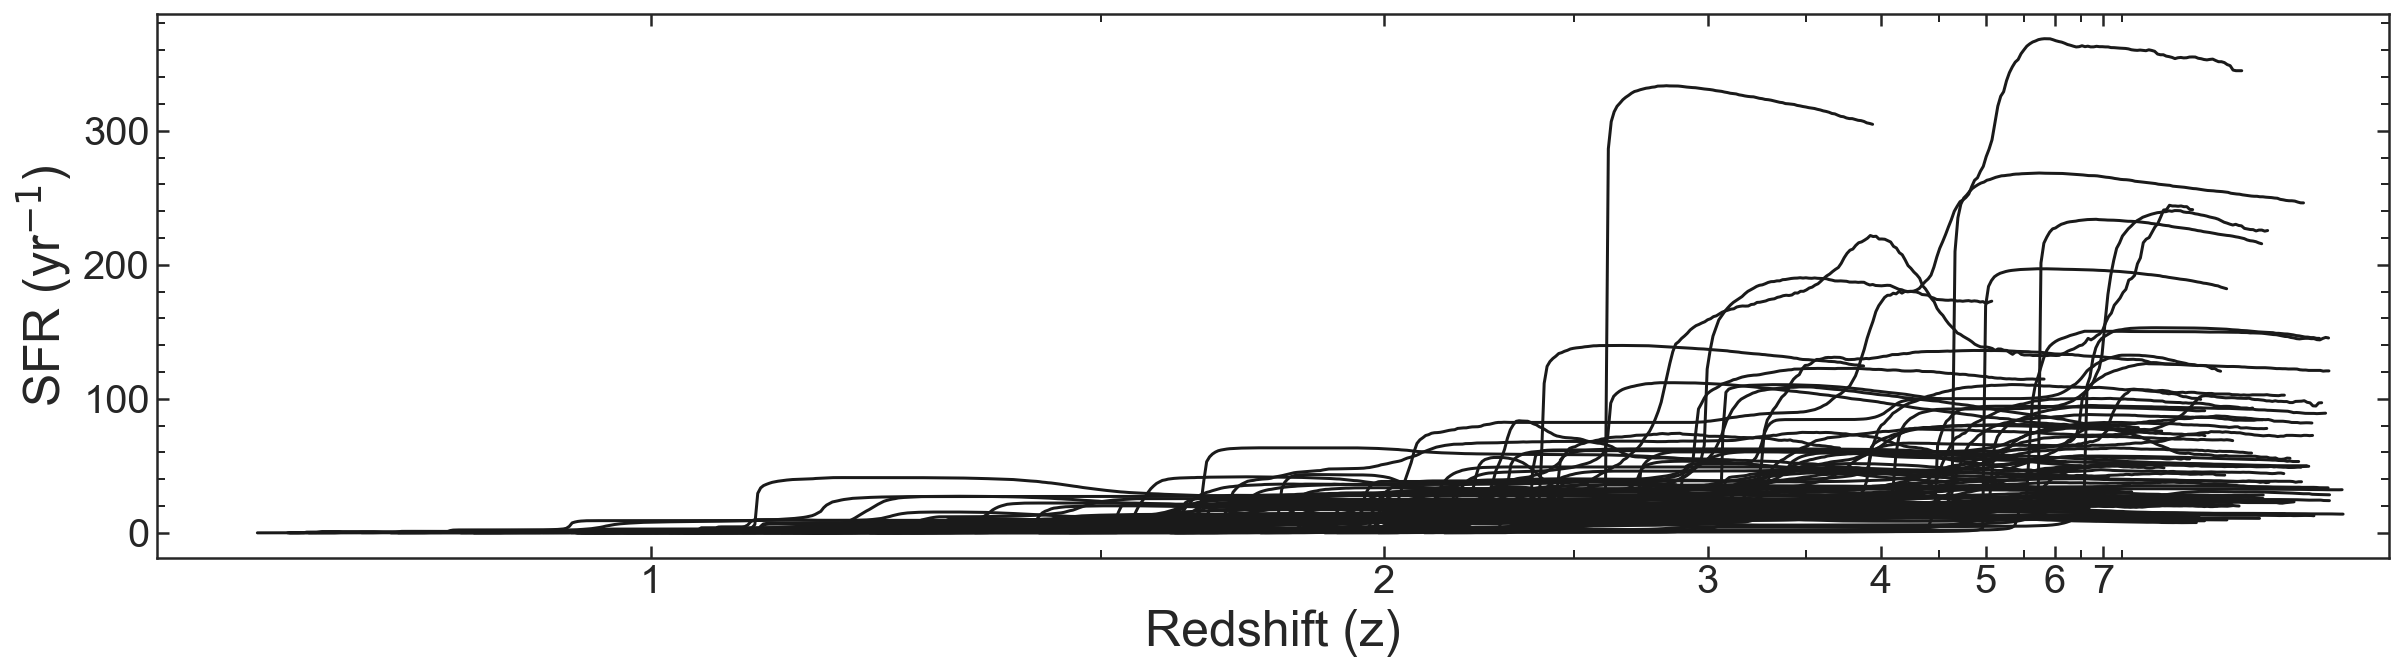

In [30]:
plt.figure(figsize=[20,5])
ax = plt.subplot()
for idx in mdb.index:
    SFH = SDB['{}'.format(mdb.id[idx])]
    plt.plot(LBT + cosmo.lookback_time(mdb.zgrism[idx]).value ,SFH, color = 'k')
plt.xticks(cosmo.lookback_time([1,2,3,4,5,6,7]).value,[1,2,3,4,5,6,7])
ax.set_xticks(cosmo.lookback_time([1.5,2.5,3.5,4.5,5.5,6.5,7.5]).value, minor = True)
plt.xlabel('Redshift (z)', fontsize=25)
plt.ylabel('SFR (yr$^{-1}$)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(cosmo.lookback_time(0.65).value, 13.7)
plt.savefig('../../Vince-ec.github.io/appendix/fullfigs/appendix_allsfh.png', bbox_inches = 'tight')    


In [ ]:
ls ../../Vince-ec.github.io/appendix/fullfigs/appendix_fullfig_1.png